<a href="https://colab.research.google.com/github/diglukhikh/neural-network-for-classifier/blob/main/RECOGNITION_CATS_and_DOGS_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание кошек и собак

Для распознавания используется сверточная нейронная сеть.
Основное содержание:
- подключение архива данных
- просмотр содержания дата сета
- создание сверточной сети и ее просмотр
- компиляция сети
- создание генераторов изображений для тренировки и проверки
- обучение нейросети 
- оценка качества и вывод графика 
- сохранение модели нейросети (структуры и весов), в облако и на локальный компьютер
- загрузка модели нейросети (с новым названием)
- компиляция загруженной нейросети
- распознавание собственных  картинок (загрузка, просмотр, подготовка, классификация на нейросети)


In [2]:
pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# ИМпорт библиотек для работы с файловой системой
# для операций с файлами и каталогами (копирование, перемещение, создание, удаление)
import shutil
import os
from matplotlib import pyplot as plt

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras.layers import Activation, Dropout, Flatten, Dense



Вспомогательные функции

In [5]:
from os import listdir, sep
from os.path import abspath, basename, isdir
def tree(dir, padding= '  ', print_files=False):
    """
    Эта функция строит дерево поддиректорий и файлов для заданной директории

    Параметры
    ----------
    dir : str
        Path to needed directory
    padding : str
        String that will be placed in print for separating files levels
    print_files : bool
        "Print or not to print" flag
    """
    cmd = "find '%s'" % dir
    files = os.popen(cmd).read().strip().split('\n')
    padding = '|  '
    for file in files:
        level = file.count(os.sep)
        pieces = file.split(os.sep)
        symbol = {0:'', 1:'/'}[isdir(file)]
        if not print_files and symbol != '/':
            continue
        print (padding*level + pieces[-1] + symbol)

In [12]:
def plot_cats_dogs_samples(train_dir, N=4):
  """
    Эта функция строит N самплов каждого класса из датасета Cats vs Dogs

    Параметры
    ----------
    train_dir : str
        Directory with train Cats vs Dogs dataset
    N : int
        Number of samples for each class 
  """
  import random
  fig, ax = plt.subplots(2,N,figsize=(5*N,5*2))

  for i,name in enumerate(['cat','dog']):
    filenames = os.listdir(os.path.join(train_dir,name))
    
    for j in range(N):
      sample = random.choice(filenames)
      image = load_img(os.path.join(train_dir,name,sample))
      ax[i][j].imshow(image)
      ax[i][j].set_xticks([])
      ax[i][j].set_yticks([])
      ax[i][j].set_title(name)
  plt.grid(False)
  plt.show()

In [6]:
# Импортируем функцию для загрузки картинок из файлов и генератор картинок
from keras.preprocessing.image import load_img, ImageDataGenerator

In [7]:
# Каталог с данными для обучения
train_dir = 'train'
# Каталог с данными для проверки
val_dir = 'val'
# Каталог с данными для тестирования
test_dir = 'test'
# Размеры изображения
img_width, img_height = 150, 150
# Размерность тензора на основе изображения для входных данных в нейронную сеть
# backend Tensorflow, channels_last
input_shape = (img_width, img_height, 3)
# Количество эпох
epochs = 1
# Размер мини-выборки
batch_size = 16
# Количество изображений для обучения
nb_train_samples = 22500
# Количество изображений для проверки
nb_validation_samples = 2500
# Количество изображений для тестирования
nb_test_samples = 2500



# Набор данных
Набор данных берется по ссылке из интернета. Можно использовать другие наборы - указать иную ссылку, в том числе ссылку на размещение архива на гугл-диске
Набор данных организуется в виде архива, где есть главная директория и поддиректории для обучения и тестирования. В каждой из них - поддиректори  с кошками и собаками.


In [8]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
#!wget -c https://drive.google.com/file/d/1rvQEbpU2lvz_hGFteYwDYZGa0fg37mWl/view?usp=sharing
!unzip -qq Cat_Dog_data.zip

--2022-10-12 11:05:41--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.200.88
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.200.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  45.2MB/s    in 13s     

2022-10-12 11:05:54 (43.4 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [9]:
base_dir = 'Cat_Dog_data'


train_dir = os.path.join(base_dir, 'train')

test_dir = os.path.join(base_dir, 'test')

In [10]:
# Посмотрим, как именно расположены директории с датасетом относительно друг друга
tree(base_dir,print_files=False)

Cat_Dog_data/
|  test/
|  |  cat/
|  |  dog/
|  train/
|  |  cat/
|  |  dog/


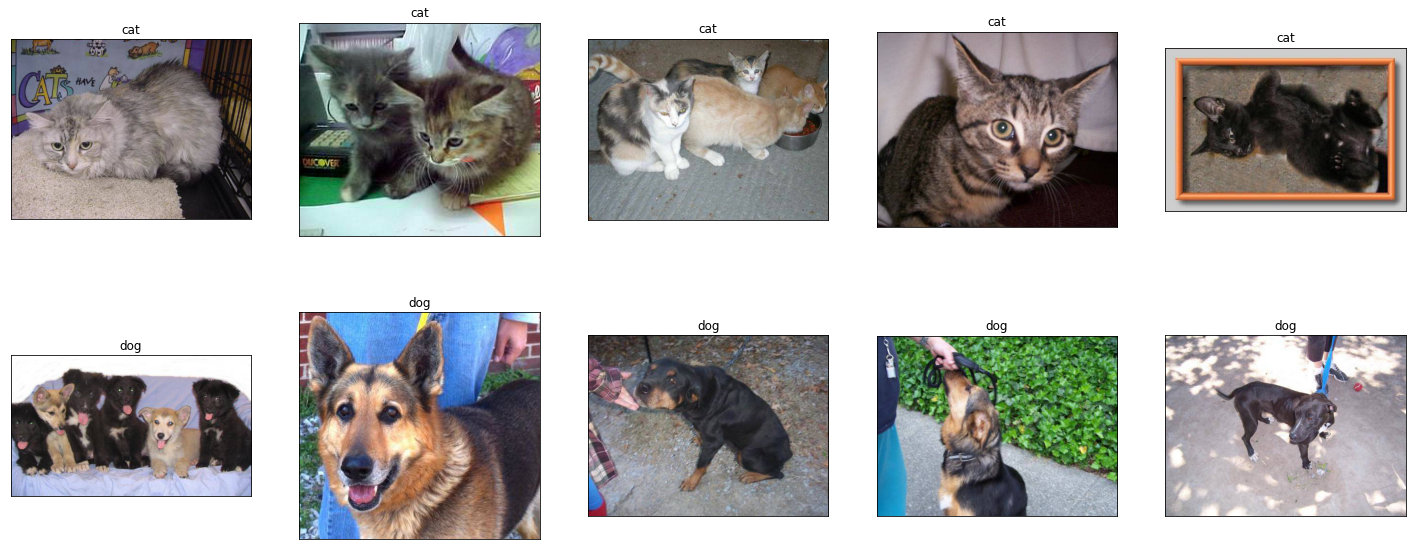

In [13]:
#Посмотрим на содержание датасета при помощи функции plot_cats_dogs_samples
plot_cats_dogs_samples(train_dir, N=5)


Создаем сверточную нейронную сеть¶

Архитектура сети

    Слой свертки, размер ядра 3х3, количество карт признаков - 32 шт., функция активации ReLU. 
    Слой подвыборки, выбор максимального значения из квадрата 2х2
    Слой свертки, размер ядра 3х3, количество карт признаков - 32 шт., функция активации ReLU.
    Слой подвыборки, выбор максимального значения из квадрата 2х2
    Слой свертки, размер ядра 3х3, количество карт признаков - 64 шт., функция активации ReLU.
    Слой подвыборки, выбор максимального значения из квадрата 2х2
    Слой преобразования из двумерного в одномерное представление
    Полносвязный слой, 64 нейрона, функция активации ReLU.
    Слой Dropout.
    Выходной слой, 1 нейрон, функция активации sigmoid

Слои с 1 по 6 используются для выделения важных признаков в изображении, а слои с 7 по 10 - для классификации.


(Conv2D(, (, ))) - сверточный слой. Слой свёртки является самым главным слоем сети. Его основное назначение – выделить признаки на входном изображении и сформировать карту признаков. Карта признаков – это всего лишь очередной тензор (массив матриц), в котором каждый канал отвечает за какой-нибудь выделенный признак. \

model.add(MaxPooling2D(pool_size=(, ))) - Слой подвыборки (пулинга)
Данный слой позволяет уменьшить пространство признаков, сохраняя наиболее важную информацию. Существует несколько разных версий слоя пулинга, среди которых максимальный пулинг, средний пулинг и пулинг суммы. Наиболее часто используется именно слой макспулинга.
Слою подвыборки требуется всего один гиперпараметр — шаг пулинга, то есть число раз, в которое нужно сократить пространственные размерности. Наиболее часто используется слой макспулинга с уменьшением размера входного тензора в два раза. Некоторые библиотеки позволяют задавать раздельные параметры уменьшения по высоте и ширине, однако чаще всего эти параметры совпадают.

model.add(Flatten()) - Слой преобразования из двумерного в одномерное представление


In [17]:
model = Sequential()
model.add(Conv2D(, (, ), input_shape=input_shape))




далее посмотрим, что из себя представляет эта сеть


In [ ]:
model.summary()

Компилируем нейронную сеть

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


Создаем генератор изображений

Генератор изображений создается на основе класса ImageDataGenerator. Генератор делит значения всех пикселей изображения на 255.


In [17]:
datagen = ImageDataGenerator(rescale=1. / 255)

Генератор данных для обучения на основе изображений из каталога


In [18]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 22500 images belonging to 2 classes.


Генератор данных для проверки на основе изображений из каталога


In [19]:
test_generator = datagen.flow_from_directory(
    #val_dir,
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2500 images belonging to 2 classes.


In [20]:
# 
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=nb_validation_samples // batch_size)

1406/1406 [==============================] - 97s 62ms/step - loss: 0.6119 - accuracy: 0.6561 - val_loss: 0.5206 - val_accuracy: 0.7484


Оцениваем качество работы сети с помощью генератора


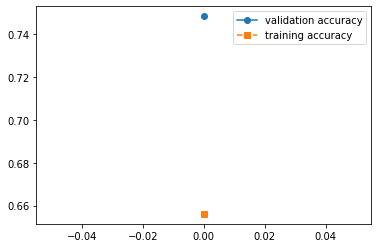

In [21]:
# Построим изменение точности на трейновой (оранжевая линия) и тестовой (синяя линия) 
# выборках
plt.plot(history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history.history['accuracy'], '--s', label='training accuracy')
plt.legend();

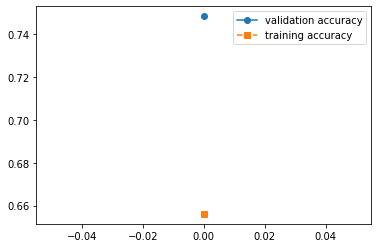

In [22]:
# Построим изменение точности на трейновой (оранжевая линия) и тестовой (синяя линия) 
# выборках
plt.plot(history.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history.history['accuracy'], '--s', label='training accuracy')
plt.legend();

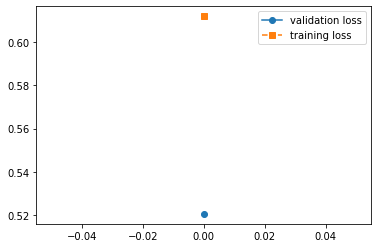

In [23]:
# Построим изменение точности на трейновой (оранжевая линия) и тестовой (синяя линия) 
# выборках
plt.plot(history.history['val_loss'], '-o', label='validation loss')
plt.plot(history.history['loss'], '--s', label='training loss')
plt.legend();

In [24]:
# Взглянем на итоговые результаты классификации на тестовой выборке 
# (функция ошибки, точность)
model.evaluate(test_generator)

   1447/Unknown - 65s 45ms/step - loss: 0.5219 - accuracy: 0.7478

KeyboardInterrupt: ignored

Далее сохраним модель сети



In [25]:
print("Сохраняем сеть")
# Сохраняем сеть для последующего использования
# Генерируем описание модели в формате json
model_json = model.to_json()
json_file = open("CAT_and_DOG.json", "w")
# Записываем архитектуру сети в файл
json_file.write(model_json)
json_file.close()
# Записываем данные о весах в файл
model.save_weights("CAT_and_DOG.h5")
print("Сохранение сети завершено")

Сохраняем сеть
Сохранение сети завершено


In [ ]:
#сохраняем на локальном компьютере
from google.colab import files
files.download("CAT_and_DOG.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#сохраняем веса сети
files.download("CAT_and_DOG.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Загружаем сохраненную сеть 


In [26]:
from keras.models import model_from_json

In [28]:
print("Загружаю сеть из файлов")
# Загружаем данные об архитектуре сети
json_file = open("CAT_and_DOG.json", "r")
loaded_model_json = json_file.read()
json_file.close()
# Создаем модель
loaded_model = model_from_json(loaded_model_json)
# Загружаем сохраненные веса в модель
loaded_model.load_weights("CAT_and_DOG.h5")
print("Загрузка сети завершена")

Загружаю сеть из файлов
Загрузка сети завершена


Далее мы можем проводить с переменной loaded_model все стандартные процедуры, обучать, прогнозировать, но сначала ее нужно скмопилировать, т.е.  вызвать ее метод compile.

In [29]:
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
# Взглянем на итоговые результаты классификации этой загруженной модели на тестовой выборке 
# (функция ошибки, точность). Она по идее совпадает со значениями ранее оубченной и сохраненной сети
loaded_model.evaluate(test_generator)

157/157 [==============================] - 7s 45ms/step - loss: 0.5214 - accuracy: 0.7480


[0.5213747024536133, 0.7480000257492065]

Распознавание своего изображения



In [ ]:
from IPython.display import Image
from tensorflow.keras.preprocessing import image

In [ ]:
f = files.upload()


NameError: ignored

In [ ]:
#смотрим, что есть в облачном хранилище, есть ли там наша картинка
!ls


sample_data


In [ ]:
# если хочется посмотреть текущйи каталог]
#!pwd
!ls /content/bin


ls: cannot access '/content/bin': No such file or directory


In [ ]:
#Покажем файл в облачном хранилище
Image ('dog.14.jpg')

NameError: ignored

In [ ]:
img_path = 'dog.14.jpg'

In [ ]:
# Преобразуем картинку в вектор , массив numpy
Image(img_path, width=150, height=150)
import numpy as np
#устанавливаем целевой размер, как и ранее при обучении - 150 на 150
img = image.load_img(img_path, target_size=(150, 150), grayscale=False)
# Преобразуем изображением в массив numpy
x = image.img_to_array(img)
x = 255 - x
x /= 255
x = np.expand_dims(x, axis=0)


NameError: ignored

In [ ]:
#Распознавание с помощью исходной нейросети (которая не загружалась)
#prediction = model.predict(x)

Распознавание изображения
с помощью модели загруженной с компьютера нейросети


In [ ]:
prediction = loaded_model.predict(x)
print (prediction)


[[0.9940996]]


In [ ]:
#prediction


In [ ]:
#bbb = np.argmax(prediction) - это возврат значения индекса наибольшего значения в массиве,  унас всегда одно значение
bbb = np.around(prediction, decimals=0)
print (bbb[0])
print("Номер класса:", bbb)
#print("Название класса:", classes[prediction])

[1.]
Номер класса: [[1.]]
